In [1]:
import numpy as np
import wrf
import matplotlib.pyplot as plt
import os, glob
from netCDF4 import Dataset
import xarray
from pandas import to_datetime, Series, DataFrame
from scipy.signal import welch
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import sys

In [2]:
plt.rc("font",size=16)

In [3]:
%matplotlib inline

In [4]:
day = 28

In [5]:
baseDir = "/glade/scratch/doubrawa/VLES"

directories = {
    "iso":os.path.join(baseDir,"03{0}15-Isotropic".format(day)),
    "non-iso":os.path.join(baseDir,"03{0}15".format(day)),
    "LES_25":"/glade/scratch/doubrawa/postProcessing/WRF_LES_25_2015-03-{0}_FILTERED.nc".format(day)}

In [67]:
dx = {"LES":25.0,
      "LES-CG":25.0,
      "VLES":333.0,
      "VLES-ISO":333.0,
      "LES_100":100.0}

In [71]:
colors = {"LES":"k","LES-CG":"k","VLES":"r","VLES-ISO":"b","LES_100":"g"}
lws    = {"LES":2,"LES-CG":2,"VLES":2,"VLES-ISO":2,"LES_100":2}
lss    = {"LES":"-","LES-CG":":","VLES":"--","VLES-ISO":"-.","LES_100":"-"}

In [8]:
height = 100.0

# open reference, LES 25-m data

In [9]:
fPath = "/glade/scratch/doubrawa/postProcessing/WRF_LES_25_2015-03-{0}_FILTERED.nc".format(day)
data_les = xarray.open_dataset(fPath)

# open LES-100 m

In [25]:
fPath = "/glade/scratch/doubrawa/postProcessing/WRF_LES_100_2015-03-{0}_FILTERED.nc".format(day)
data_les100 = xarray.open_dataset(fPath)

# open VLES

In [10]:
fPath = "/glade/scratch/doubrawa/postProcessing/WRF_VLES_2015-03-{0}_FILTERED.nc".format(day)
data_vles = xarray.open_dataset(fPath)
fPath = "/glade/scratch/doubrawa/postProcessing/WRF_VLES-ISO_2015-03-{0}_FILTERED.nc".format(day)
data_vles_iso = xarray.open_dataset(fPath)

# grab variables

In [11]:
datetime = data_les.time[-2]

In [12]:
datetime_rounded = to_datetime("{0:%Y-%m-%d %H:%M}".format(to_datetime(datetime.data)))

In [13]:
datetime_local = datetime_rounded.tz_localize("UTC").tz_convert("US/Mountain")

In [14]:
c = {} 
x = {}
y = {}

In [15]:
c["LES"] = data_les["w"].sel(time=datetime)
x["LES"] = data_les.west_east
y["LES"] = data_les.south_north

In [16]:
c["LES-CG"] = data_les["w_filt"].sel(time=datetime)
x["LES-CG"] = x["LES"]
y["LES-CG"] = y["LES"]

In [17]:
c["VLES"] = data_vles["w_filt"].sel(time=datetime_rounded)
x["VLES"] = data_vles.west_east
y["VLES"] = data_vles.south_north

In [18]:
c["VLES-ISO"] = data_vles_iso["w_filt"].sel(time=datetime_rounded)
x["VLES-ISO"] = x["VLES"]
y["VLES-ISO"] = y["VLES"]

In [26]:
c["LES_100"] = data_les100["w"].sel(time=datetime)
x["LES_100"] = data_les100.west_east
y["LES_100"] = data_les100.south_north

# visualize

In [27]:
plt.rc("font",size=14)

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


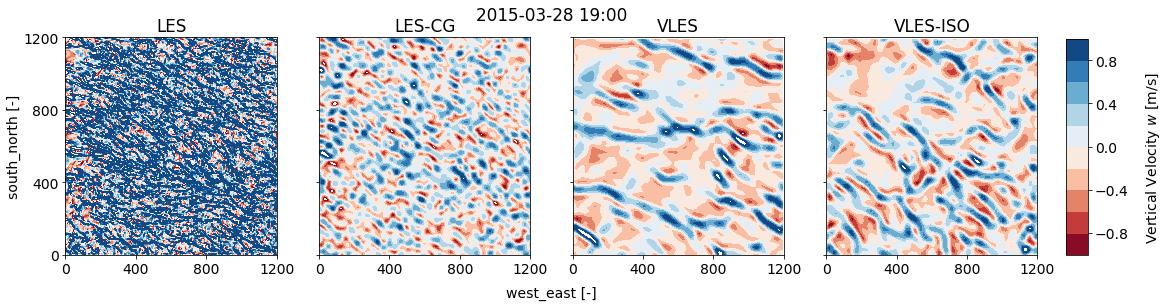

In [38]:
fig = plt.figure(figsize=(20,4))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
axbig.set_xlabel("west_east [-]",labelpad=10)
axbig.set_ylabel("south_north [-]",labelpad=15)
axbig.set_title("{0:%Y-%m-%d %H:%M}".format(datetime_rounded),y=1.05)

ax  = {}
for iax, key in enumerate(["LES","LES-CG","VLES","VLES-ISO"]):
    
    xx = x[key]
    yy = y[key]
    cc = c[key]
    
    ax[iax] = fig.add_subplot(1,4,iax+1)
    
    p = ax[iax].contourf(xx,yy,cc,levels=np.arange(-1,1.01,0.2),cmap="RdBu")
    
    if iax>0:
        plt.setp(ax[iax].get_yticklabels(), visible=False)

        fig.subplots_adjust(right=0.8)
        
    ax[iax].set_xlim([0,1200])
    ax[iax].set_ylim([0,1200])    
    
    ax[iax].set_xticks(np.arange(0,1201,400))    
    ax[iax].set_yticks(np.arange(0,1201,400))        
    
    ax[iax].set_title(key)

cbar_ax = fig.add_axes([0.82, 0.125, 0.015, 0.75])
clb = fig.colorbar(p, cax=cbar_ax)
clb.set_label(r'Vertical Velocity $w$ [m/s]', labelpad=15, y=0.45)

# Correlations

In [20]:
autocorr_2d_primes  = {key:{"along_we":{},"along_sn":{}} for key in c.keys()}
autocorr_1d_primes  = {key:{"along_we":{},"along_sn":{}} for key in c.keys()}

In [48]:

    autocorr_2d_primes["LES_100"] = {}
    autocorr_1d_primes["LES_100"] = {}    

In [49]:
for key in ["along_we","along_sn"]:
    autocorr_2d_primes["LES_100"][key] = {}
    autocorr_1d_primes["LES_100"][key] = {}    

In [51]:
for key in ["LES_100"]:
    print (key)
    cc = c[key] - np.mean(c[key])
    nj, ni      = cc.shape
    for direction in autocorr_2d_primes[key].keys():
        print (direction)
        autocorr_2d_primes[key][direction] = DataFrame(index=range(ni),columns=range(nj))
        if direction=="along_we":
            for j in range(nj):
                tmp = Series(cc[j,:])
                autocorr_2d_primes[key][direction][j] = np.array([ tmp.autocorr(i) for i in range(ni) ])
        else:
            for i in range(ni):
                tmp = Series(cc[:,i])
                autocorr_2d_primes[key][direction][i] = np.array([ tmp.autocorr(j) for j in range(nj) ])             
        autocorr_1d_primes[key][direction] = autocorr_2d_primes[key][direction].mean(axis=1)

LES_100
along_we


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


along_sn


In [57]:
autocorr_2d  = autocorr_2d_primes
autocorr_1d  = autocorr_1d_primes

# Compute integral length scale

In [68]:
L_e     = {key:{} for key in autocorr_1d.keys()}
L_0_int = {key:{} for key in autocorr_1d.keys()}

In [69]:
for key in autocorr_1d.keys():
    for direction in ["along_we","along_sn"]:

        y = autocorr_1d[key][direction].values 
        x = autocorr_1d[key][direction].index*dx[key]

        x_int = np.arange(0,5001,1)
        y_int = np.interp(x_int,x,y)

        idx_e = np.where(y_int<=np.exp(-1))[0][0]
        y_e   = y_int[idx_e]
        x_e   = x_int[idx_e]

        
        idx_0     = np.where(y_int<0)[0][0]
        xx_0      = x_int[0:idx_0+1]
        yy_0      = y_int[0:idx_0+1]
        x_0_int   = np.trapz(yy_0,xx_0)
        
        L_e[key][direction] = x_e
        L_0_int[key][direction] = x_0_int

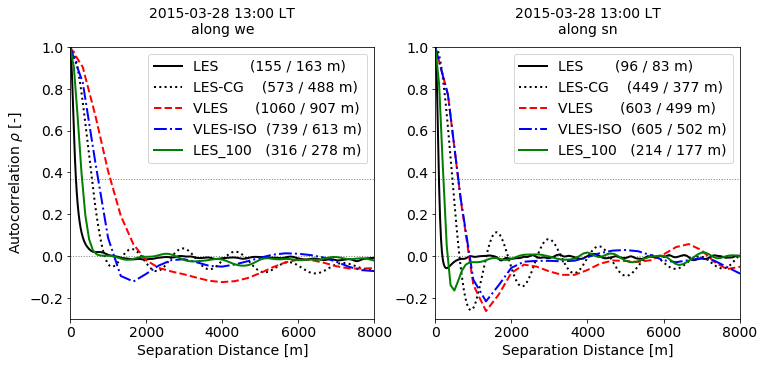

In [72]:
fig = plt.figure(figsize=(12,5))
ax  = {}

for iax,direction in enumerate(["along_we","along_sn"]):

    ax[iax] = fig.add_subplot(1,2,iax+1)
    ax[iax].axhline(y=0.0,color='gray',linestyle=":",lw=1)
    ax[iax].axhline(y=np.exp(-1),color='gray',linestyle=":",lw=1)
    
    for key in c.keys():
        y = autocorr_1d[key][direction].values
        x = autocorr_1d[key][direction].index*dx[key]
        ax[iax].plot(x,y,lw=lws[key],color=colors[key],ls=lss[key],label="{0:9s} ({1:.0f} / {2:.0f} m)".format(key,L_e[key][direction], L_0_int[key][direction]))
    
    ax[iax].set_xlim([0,8000])
    ax[iax].set_ylim([-0.3,1.0])
    ax[iax].set_xlabel("Separation Distance [m]")
    ax[iax].set_title("{0:%Y-%m-%d %H:%M} LT".format(datetime_local)+"\n"+"along {0}".format(direction.split("_")[-1]),fontsize=14,y=1.025)
    
    if iax==0:
        ax[iax].set_ylabel(r"Autocorrelation $\rho$ [-]")    
    plt.legend()

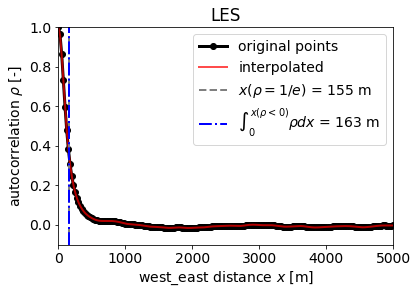

In [201]:
plt.plot(x,y,'o-k',lw=3,label="original points")
plt.plot(x_int,y_int,'-r',ms=0.5,lw=2,alpha=0.7,label="interpolated")


plt.xlim([0,5000])
plt.ylim([-0.1,1.0])

plt.axvline(x=x_e,color='gray',linestyle="--",lw=2,label=r"$x(\rho=1/e)$ = {0:.0f} m".format(x_e))
# plt.axvline(x=x_e_int,color='gray',linestyle="-",lw=4,label=r"$ \int_0^{{x(\rho=1/e)}}$ = {0:.0f} m".format(x_e_int))

# plt.axvline(x=x_0,color='#01DF01',linestyle="--",lw=2,label=r"First $x(\rho<0)$ = {0:.0f} m".format(x_0))
plt.axvline(x=x_0_int,color='b',linestyle="-.",lw=2,label=r"$ \int_0^{{x(\rho<0)}} \rho dx $ = {0:.0f} m".format(x_0_int))

plt.xlabel(r"west_east distance $x$ [m]")
plt.ylabel(r"autocorrelation $\rho$ [-]")

plt.title(key)

plt.legend()

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


436.00373854943393